In [96]:
import os
import numpy as np
from numpy.fft import fft2, ifft2
import matplotlib.pyplot as plt
import cv2
from skimage.metrics import peak_signal_noise_ratio, structural_similarity 
from skimage.transform import resize
from scipy.signal.windows import gaussian
from scipy.signal import convolve2d
from skimage import util
from skimage.restoration import richardson_lucy as rl
from PIL import Image
from IPython.display import display
from sklearn.metrics import mean_squared_error


In [150]:

def motion_kernel(kernel_size=3):
    h = np.eye(kernel_size) / kernel_size
    return h
def gaussian_blur(img, kernel_size = 3):

    dummy = np.copy(img)

    h = gaussian(kernel_size, kernel_size / 3).reshape(kernel_size, 1)
    h = np.dot(h, h.transpose())
    h /= np.sum(h)

    dummy = convolve2d(dummy, h, mode = 'valid')
    return dummy

def gaussian_kernel(kernel_size = 3):
    h = gaussian(kernel_size, kernel_size / 3).reshape(kernel_size, 1)
    h = np.dot(h, h.transpose())
    h /= np.sum(h)
    return h

def inverse_filter(img, kernel):
    # Normalize the kernel to ensure it sums to 1
    kernel /= np.sum(kernel)
    
    # Create a copy of the input image and perform Fourier transform
    dummy = np.copy(img)
    dummy = fft2(dummy)
    
    # Perform Fourier transform on the kernel and pad it to match the image's size
    kernel = fft2(kernel, s=img.shape)
    
    # Avoid division by zero or very small values in the kernel
    epsilon = 1e-8
    kernel[np.abs(kernel) < epsilon] = epsilon  # Set small values to epsilon
    
    # Apply the inverse filter in the frequency domain (divide image by kernel)
    dummy = dummy / kernel
    
    # Perform the inverse Fourier transform to bring the image back to the spatial domain
    dummy = np.abs(ifft2(dummy))
    
    return dummy  # Return the restored image

def wiener_filter(img, kernel, K):
    # Normalize the kernel by ensuring its sum is 1
    kernel /= np.sum(kernel)
    
    # Create a copy of the input image to avoid modifying the original
    dummy = np.copy(img)
    
    # Perform Fourier transform on the image to convert it to the frequency domain
    dummy = fft2(dummy)
    
    # Perform Fourier transform on the kernel, padded to match the image size
    kernel = fft2(kernel, s=img.shape)
    
    # Apply Wiener filtering: conjugate the kernel and use it with the regularization term (K)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    
    # Apply the filter by multiplying the transformed image with the filtered kernel
    dummy = dummy * kernel
    
    # Perform inverse Fourier transform to bring the result back to the spatial domain
    dummy = np.abs(ifft2(dummy))
    
    # Return the filtered image
    return dummy

def motion_blur(img,  kernel_size = 3):

    dummy = np.copy(img)

    h = np.eye(kernel_size) / kernel_size

    dummy = convolve2d(dummy, h, mode = 'valid')
    return dummy

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


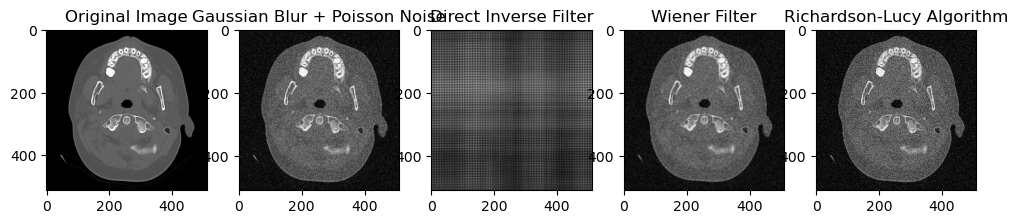

-13.372722564388322
10.353424812770838
10.385482112980792


In [141]:
file_name = os.path.join('braintumor.jpg') 
img = rgb2gray(plt.imread(file_name))



gaussian_blurred_img = gaussian_blur(img,  kernel_size = 3)

# Normalize the blurred image to [0, 1]
gaussian_blurred_img = (gaussian_blurred_img - np.min(gaussian_blurred_img)) / (np.max(gaussian_blurred_img) - np.min(gaussian_blurred_img))


gaussian_noisy_img2 = util.random_noise(gaussian_blurred_img, mode="gaussian",var=0.02)


# gaussian_kernel = gaussian_kernel(5)
kernel = gaussian_kernel(3)  # Make sure this is defined and applied correctly



# applying the filters to images with gaussian blur + poisson noise
g_inv_filtered_img2 = inverse_filter(gaussian_noisy_img2,kernel)
g_w_filtered_img2 = wiener_filter(gaussian_noisy_img2,kernel,30)
g_rl_img2 = rl(gaussian_noisy_img2,kernel,23)


fig = plt.figure(figsize=(12, 10))

fig.add_subplot(1, 5, 1)
plt.imshow(img, cmap = 'gray')
plt.title("Original Image")

fig.add_subplot(1, 5, 2)
plt.imshow(gaussian_noisy_img2, cmap = 'gray')
plt.title("Gaussian Blur + Poisson Noise")

fig.add_subplot(1, 5, 3)
plt.imshow(g_inv_filtered_img2, cmap = 'gray')
plt.title("Direct Inverse Filter")

fig.add_subplot(1, 5, 4)
plt.imshow(g_w_filtered_img2, cmap = 'gray')
plt.title("Wiener Filter")

fig.add_subplot(1, 5, 5)
plt.imshow(g_rl_img2, cmap = 'gray')
plt.title("Richardson-Lucy Algorithm")

plt.show()

g_inv_filtered_img2 = resize(g_inv_filtered_img2, img.shape, mode='reflect', anti_aliasing=True)
g_w_filtered_img2 = resize(g_w_filtered_img2, img.shape, mode='reflect', anti_aliasing=True)
g_rl_img2 = resize(g_rl_img2, img.shape, mode='reflect', anti_aliasing=True)

print(peak_signal_noise_ratio(img,g_inv_filtered_img2, data_range=255.0))
print(peak_signal_noise_ratio(img, g_w_filtered_img2, data_range=255.0))
print(peak_signal_noise_ratio(img, g_rl_img2, data_range=255.0))




In [125]:
file_name = os.path.join('braintumor.jpg') 
img = rgb2gray(plt.imread(file_name))
g_rl_img2 = rl(gaussian_noisy_img2,kernel,23)


In [139]:
new_width = 256
new_height = 256
resized_img = cv2.resize(img, (new_width, new_height))

resized_inv = cv2.resize(g_inv_filtered_img2, (new_width, new_height))

resized_w = cv2.resize(g_w_filtered_img2, (new_width, new_height))


resized_rl = cv2.resize(g_rl_img2, (new_width, new_height))

psnr1 = cv2.PSNR(resized_img, resized_inv)
psnr2 = cv2.PSNR(resized_img, resized_w)
psnr3 = cv2.PSNR(resized_img, resized_rl)

print(psnr1)
print(psnr2)
print(psnr3)

10.41403507581866
10.381259414585546
10.414274832906834
